<a href="https://colab.research.google.com/github/makkimaki/pymc-practice/blob/main/Causal_analysis_with_PyMC_Answering_%22What_If%3F%22_with_the_new_do_operator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal analysis with PyMC: Answering "What If?" with the new do operator

## 問題意識
> Machine learning methods might help us predict what's going to happen with great accuracy, but what's the value of that if it doesn't tell us what to do to achieve a desirable outcome.

何が起こるか？を正確に「予測」してくれても、望む結果を得るために***何をすべきか？***がわからなければ意義が薄い


- parameter recovery (パラメータリカバリー)のエクササイズ
- causal analysis（因果分析）

### 問題設定
> Estimate the effectiveness of the paid Google search ads in driving sales.

Google広告が売り上げに与える効果

In [1]:
!pip -q -q -q install japanize-matplotlib
!pip -q -q -q install seaborn==0.12.2
!pip -q -q -q install numpyro
!pip -q -q -q install 'pymc>=5.9'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 4.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
# from IPython.display import display
import seaborn as sns
import pymc as pm
import arviz as az
import scipy
import scipy.stats as stats
from numpy.random import multinomial
import matplotlib as mtl
import pytensor as pt
from packaging import version
from mpl_toolkits.mplot3d import Axes3D
# from IPython.core.pylabtools import figsize
# figsize(10, 4)
mtl.style.use("ggplot")

print(f"{pm.__version__=}")
print(f"{sns.__version__=}")
print(f"{np.__version__=}")
print(f"{scipy.__version__=}")
print(f"{pd.__version__=}")
np.set_printoptions(precision=3, floatmode="fixed")
plt.rcParams["font.size"] = 8
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.grid"] = True
# pd.options.display.float_format = "[:.3f]".format
pd.set_option("display.max_columns", None)

# check we have the required versions
assert version.parse(pm.__version__) >= version.parse("5.8.0")

# import the new functionality
from pymc import do, observe

pm.__version__='5.10.4'
sns.__version__='0.12.2'
np.__version__='1.25.2'
scipy.__version__='1.11.4'
pd.__version__='2.0.3'


In [3]:
SEED = 42

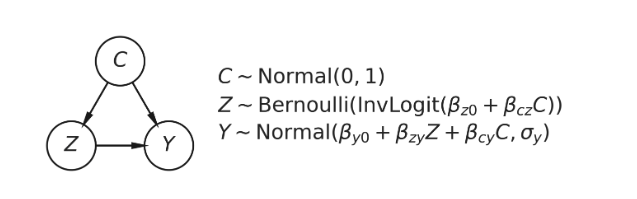


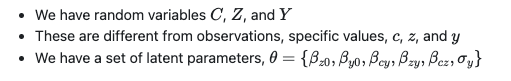


- C: TV ads
- Z: Google Ads on/off
- Y: sales outcome


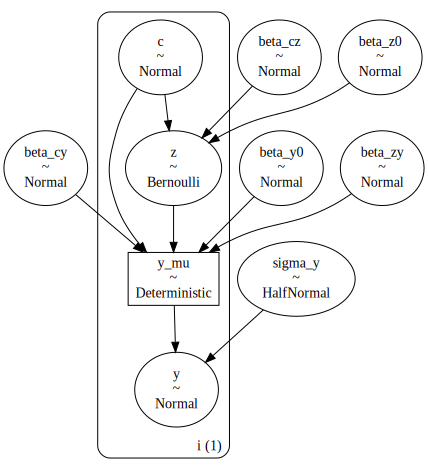

In [4]:
with pm.Model(coords_mutable={"i": [0]}) as model_generative:
    # priors on Y <- C -> Z
    beta_y0 = pm.Normal("beta_y0")
    beta_cy = pm.Normal("beta_cy")
    beta_cz = pm.Normal("beta_cz")
    # priors on Z -> Y causal path
    beta_z0 = pm.Normal("beta_z0")
    beta_zy = pm.Normal("beta_zy")
    # observation noise on Y
    sigma_y = pm.HalfNormal("sigma_y")
    # core nodes and causal relationships
    c = pm.Normal("c", mu=0, sigma=1, dims="i")
    z = pm.Bernoulli("z", p=pm.invlogit(beta_z0 + beta_cz * c), dims="i")
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_zy * z) + (beta_cy * c), dims="i")
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, dims="i")

g = pm.model_to_graphviz(model_generative)
display(g)

In [5]:
true_ATE = 0.0

true_values = {
    "beta_z0": 0.0,
    "beta_y0": 0.0,
    "beta_cz": 1.5,
    "beta_zy": true_ATE,
    "beta_cy": 1.0,
    "sigma_y": 0.2,
}

model_simulate = do(model_generative, true_values)

`do`オペレータを使って介入をシミュレーションする

この新しいモデルからサンプルを得るために、$P(C, Z, Y|\theta)$分布からサンプリングする。
- `pm.sample_prior_predictive` ← これを使う
- `pm.sample` ← 推論で使うもの



In [6]:
N = 100

with model_simulate:
    simulate = pm.sample_prior_predictive(samples=N, random_seed=SEED)

observed = {
    "c": simulate.prior["c"].values.flatten(),
    "y": simulate.prior["c"].values.flatten(),
    "z": simulate.prior["z"].values.flatten(),
}

df = pd.DataFrame(observed).sort_values("c", ascending=False).reset_index(drop=True)
df.head()

,c,y,z
0,2.743181,2.743181,1
1,2.713103,2.713103,1
2,2.137510,2.137510,1
3,1.845935,1.845935,1
4,1.820203,1.820203,1


In [7]:
df.describe()

,c,y,z
count,100.000000,100.000000,100.000000
mean,0.035793,0.035793,0.490000
std,1.155697,1.155697,0.502418
min,-2.287180,-2.287180,0.000000
25%,-0.911861,-0.911861,0.000000
50%,-0.090103,-0.090103,0.000000
75%,1.025817,1.025817,1.000000
max,2.743181,2.743181,1.000000


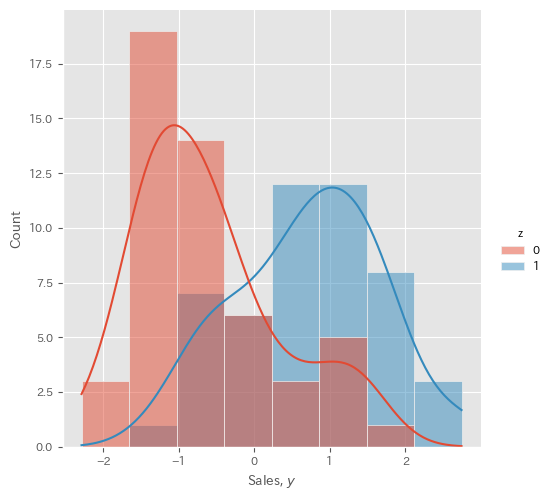

In [15]:
ax = sns.displot(df, x="y", hue="z", kde=True)
ax.set(xlabel="Sales, $y$");